# Land cover types

## 1 Overview

- **Main ideas:**
    - Land cover classes for South America using `MCD12C1 MODIS version 006` product.
    - Spatial resolution is `0.05x0.05` degrees and we show the results for 2018.
    - Data format is `HDF4`.
    - We regrid data to the ERA-INTERIM `0.75x0.75°` grid for `South America` and export the results to a netcdf file.
- **References:**
    - [MODIS/Terra+Aqua Land Cover Type CMG Yearly L3 Global 0.05 Deg](https://lpdaac.usgs.gov/products/mcd12c1v006/).

## 2 Initial setup

In [1]:
# Load packages.
import sys
import warnings

import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# My package.
repos = "/home/alex/Dropbox/repositories/cdlearn/"
if repos not in sys.path:
    sys.path.append(repos)

# Work in progress.    
from cdlearn.maps import south_america
from cdlearn.pixels import EraInterimGrid

In [3]:
# Main directory.
FILE_PATH = "/media/alex/ALEXDATA/data_sets/MODIS/LAND_COVER/" + \
            "MCD12C1.A2018001.006.2019200161458.hdf" # 2018 data file.

# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/single_variables/"

## 3 Load and preprocess data

In [4]:
# Read meta data.
DS = xr.open_dataset(FILE_PATH, engine='pynio')

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:                                (Num_IGBP_Classes_MOD12C1: 17, Num_LAI_FPAR_Classes_MOD12C1: 11, Num_UMD_Classes_MOD12C1: 16, XDim_MOD12C1: 7200, YDim_MOD12C1: 3600)
Dimensions without coordinates: Num_IGBP_Classes_MOD12C1, Num_LAI_FPAR_Classes_MOD12C1, Num_UMD_Classes_MOD12C1, XDim_MOD12C1, YDim_MOD12C1
Data variables:
    Majority_Land_Cover_Type_1             (YDim_MOD12C1, XDim_MOD12C1) float32 ...
    Majority_Land_Cover_Type_1_Assessment  (YDim_MOD12C1, XDim_MOD12C1) float32 ...
    Land_Cover_Type_1_Percent              (YDim_MOD12C1, XDim_MOD12C1, Num_IGBP_Classes_MOD12C1) float32 ...
    Majority_Land_Cover_Type_2             (YDim_MOD12C1, XDim_MOD12C1) float32 ...
    Majority_Land_Cover_Type_2_Assessment  (YDim_MOD12C1, XDim_MOD12C1) float32 ...
    Land_Cover_Type_2_Percent              (YDim_MOD12C1, XDim_MOD12C1, Num_UMD_Classes_MOD12C1) float32 ...
    Majority_Land_Cover_Type_3             (YDim_MOD12C1, XDim_MOD12C1) float32 ...
    Majorit

In [5]:
# Major class occurrence (Num_IGBP_Classes=17).
DA = DS.Majority_Land_Cover_Type_1
print(">>> Global data size in GB (as float):", DA.nbytes / 1e9)
print("")
print(DA)

>>> Global data size in GB (as float): 0.10368

<xarray.DataArray 'Majority_Land_Cover_Type_1' (YDim_MOD12C1: 3600, XDim_MOD12C1: 7200)>
[25920000 values with dtype=float32]
Dimensions without coordinates: YDim_MOD12C1, XDim_MOD12C1
Attributes:
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               [0]
    evergreen_needleleaf_forest:         [1]
    evergreen_broadleaf_forest:          [2]
    deciduous_needleleaf_forest:         [3]
    deciduous_broadleaf_forest:          [4]
    mixed_forests:                       [5]
    closed_shrubland:                    [6]
    open_shrublands:                     [7]
    woody_savannas:                      [8]
    savannas:                            [9]
    grasslands:                          [10]
    permanent_wetlands:                  [11]
    croplands:                           [

In [6]:
# Load this data into memory as an xarray DataArray object.
DA = DA.astype(np.int8) # Less memory.
print(">>> Global data size in GB (as int):", DA.nbytes / 1e9)
with ProgressBar():
    DA = DA.load()

# Coordinates as usual.    
DA = DA.rename({"YDim_MOD12C1": "lat", "XDim_MOD12C1": "lon"})
DA = DA[::-1, :] # This is trick! It couldn't work otherwise when plotting data!
DA.coords["lat"] = ("lat", np.arange(-90, 90, 0.05)) # Ascending order.
DA.coords["lon"] = ("lon", np.arange(-180, 180, 0.05)) # Ascending order.

# South America.
DA = DA.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Final form.
print(">>> South America data size in GB (as int):", DA.nbytes / 1e9)
print("")
print(DA)

>>> Global data size in GB (as int): 0.02592
>>> South America data size in GB (as int): 0.00192

<xarray.DataArray 'Majority_Land_Cover_Type_1' (lat: 1600, lon: 1200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [8, 4, 4, ..., 0, 0, 0],
       [4, 8, 4, ..., 0, 0, 0]], dtype=int8)
Coordinates:
  * lat      (lat) float64 -59.95 -59.9 -59.85 -59.8 ... 19.85 19.9 19.95 20.0
  * lon      (lon) float64 -90.0 -89.95 -89.9 -89.85 ... -30.15 -30.1 -30.05


## 4 Visualization

In [7]:
%%time

# All land types.
classes_dict_swapped = {
    "Water":                               0,
    "Evergreen needleleaf forest":         1,
    "Evergreen broadleaf forest":          2,
    "Deciduous needleleaf forest":         3,
    "Deciduous broadleaf forest":          4,
    "Mixed forests":                       5,
    "Closed shrubland":                    6,
    "Open shrublands":                     7,
    "Woody savannas":                      8,
    "Savannas":                            9,
    "Grasslands":                          10,
    "Permanent wetlands":                  11,
    "Croplands":                           12,
    "Urban and built up":                  13,
    "Cropland natural vegetation mosaic":  14,
    "Snow and ice":                        15,
    "Barren or sparsely vegetated":        16
}    

# Swap keys and values of the previous dict.
classes_dict = dict([(value, key) for key, value in classes_dict_swapped.items()]) 

# Count ocurrences on South America.
classes, counts = np.unique(DA.values.flatten(), return_counts=True)

# No occurrence for class 3 (Deciduous needleleaf forest).
classes = np.insert(classes, 3, 3)
counts = np.insert(counts, 3, 0)

# All classes percentages.
total = np.sum(counts)
percentages = counts / total * 100

# Show results.
print(">>> Total of grid points:", total)
print(">>> Code; Count; Percentage; Class")
for CLASS, COUNT, PERCENTAGE in zip(classes, counts, percentages):
    print("*", str(CLASS) + "; ", 
          str(COUNT) +  "; ", "%.2f%%" %(PERCENTAGE) + "; ", 
          classes_dict[CLASS])

>>> Total of grid points: 1920000
>>> Code; Count; Percentage; Class
* 0;  1289238;  67.15%;  Water
* 1;  1437;  0.07%;  Evergreen needleleaf forest
* 2;  217912;  11.35%;  Evergreen broadleaf forest
* 3;  0;  0.00%;  Deciduous needleleaf forest
* 4;  9249;  0.48%;  Deciduous broadleaf forest
* 5;  3505;  0.18%;  Mixed forests
* 6;  624;  0.03%;  Closed shrubland
* 7;  35206;  1.83%;  Open shrublands
* 8;  31381;  1.63%;  Woody savannas
* 9;  130653;  6.80%;  Savannas
* 10;  137259;  7.15%;  Grasslands
* 11;  4285;  0.22%;  Permanent wetlands
* 12;  28275;  1.47%;  Croplands
* 13;  2037;  0.11%;  Urban and built up
* 14;  4107;  0.21%;  Cropland natural vegetation mosaic
* 15;  1271;  0.07%;  Snow and ice
* 16;  23561;  1.23%;  Barren or sparsely vegetated
CPU times: user 44.8 ms, sys: 4.53 ms, total: 49.3 ms
Wall time: 45.8 ms


### 4.1 Original spatial resolution

CPU times: user 3.62 s, sys: 62.6 ms, total: 3.68 s
Wall time: 3.72 s


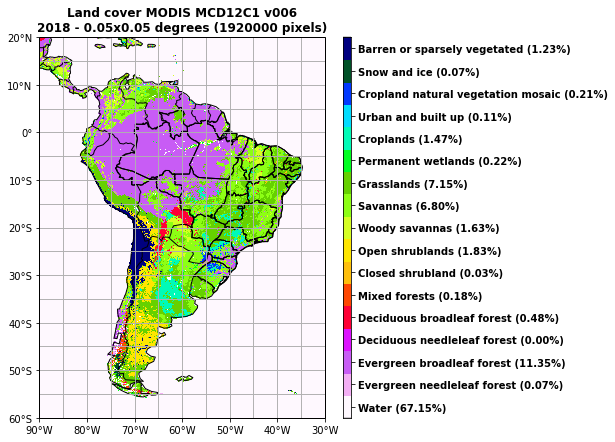

In [8]:
%%time

# Grid for one map.
axgr = south_america(
    figsize=(14, 7),
    nrows_ncols=(1, 1),
    titles=[
        f"Land cover MODIS MCD12C1 v006\n2018 - 0.05x0.05 degrees ({total} pixels)"
    ]
)

# Plot mean results.
plotmap = DA.plot(
    ax=axgr[0],
    vmin=int(0),
    vmax=int(16),
    levels=np.arange(0, 18, 1),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)   

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.cbar_axis.set_ticks(np.arange(0, 17, 1) + 0.5)

# Make colorbar y ticks as strings.
ylabels = [classes_dict[key] + str(" (%.2f%%)" %(percentages[key])) for key in range(17)]
cb.cbar_axis.axes.yaxis.set_ticklabels(ylabels, weight="bold")

# Save figures.
plt.savefig(
    fig_path + "land_cover_igbp_modis.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

### 4.2 Regridded

In [9]:
# South america longitudes.
lons = np.array(
    [-90.  , -89.25, -88.5 , -87.75, -87.  , -86.25, -85.5 , -84.75, -84.  ,
     -83.25, -82.5 , -81.75, -81.  , -80.25, -79.5 , -78.75, -78.  , -77.25,
     -76.5 , -75.75, -75.  , -74.25, -73.5 , -72.75, -72.  , -71.25, -70.5 ,
     -69.75, -69.  , -68.25, -67.5 , -66.75, -66.  , -65.25, -64.5 , -63.75,
     -63.  , -62.25, -61.5 , -60.75, -60.  , -59.25, -58.5 , -57.75, -57.  ,
     -56.25, -55.5 , -54.75, -54.  , -53.25, -52.5 , -51.75, -51.  , -50.25,
     -49.5 , -48.75, -48.  , -47.25, -46.5 , -45.75, -45.  , -44.25, -43.5 ,
     -42.75, -42.  , -41.25, -40.5 , -39.75, -39.  , -38.25, -37.5 , -36.75,
     -36.  , -35.25, -34.5 , -33.75, -33.  , -32.25, -31.5 , -30.75, -30.  ]
)

# South America latitudes.
lats = np.array(
    [-60.  , -59.25, -58.5 , -57.75, -57.  , -56.25, -55.5 , -54.75, -54.  ,
     -53.25, -52.5 , -51.75, -51.  , -50.25, -49.5 , -48.75, -48.  , -47.25,
     -46.5 , -45.75, -45.  , -44.25, -43.5 , -42.75, -42.  , -41.25, -40.5 ,
     -39.75, -39.  , -38.25, -37.5 , -36.75, -36.  , -35.25, -34.5 , -33.75,
     -33.  , -32.25, -31.5 , -30.75, -30.  , -29.25, -28.5 , -27.75, -27.  ,
     -26.25, -25.5 , -24.75, -24.  , -23.25, -22.5 , -21.75, -21.  , -20.25,
     -19.5 , -18.75, -18.  , -17.25, -16.5 , -15.75, -15.  , -14.25, -13.5 ,
     -12.75, -12.  , -11.25, -10.5 ,  -9.75,  -9.  ,  -8.25,  -7.5 ,  -6.75,
     -6.  ,  -5.25,  -4.5 ,  -3.75,  -3.  ,  -2.25,  -1.5 ,  -0.75,   0.  ,
     0.75,   1.5 ,   2.25,   3.  ,   3.75,   4.5 ,   5.25,   6.  ,   6.75,
     7.5 ,   8.25,   9.  ,   9.75,  10.5 ,  11.25,  12.  ,  12.75,  13.5 ,
     14.25,  15.  ,  15.75,  16.5 ,  17.25,  18.  ,  18.75,  19.5 ]
)

# In accordance with ERA-INTERIM pos-processed data.
NEW_GRID = xr.Dataset({"lat": (["lat"], lats), "lon": (["lon"], lons)})

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 107, lon: 81)
Coordinates:
  * lat      (lat) float64 -60.0 -59.25 -58.5 -57.75 ... 17.25 18.0 18.75 19.5
  * lon      (lon) float64 -90.0 -89.25 -88.5 -87.75 ... -31.5 -30.75 -30.0
Data variables:
    *empty*


In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DA.to_dataset(),
    ds_out=NEW_GRID,
    method="nearest_s2d",
    periodic=False, # Not global data!
    reuse_weights=True
)

# Do it.
DA_reg = REGRIDDER(DA)

# Sea mask.
DA_reg = EraInterimGrid.add_land_mask(DA_reg)

# Delete regridder file.
REGRIDDER.clean_weight_file()

Create weight file: nearest_s2d_1600x1200_107x81.nc
Remove file nearest_s2d_1600x1200_107x81.nc
CPU times: user 5.71 s, sys: 120 ms, total: 5.83 s
Wall time: 5.85 s


In [11]:
# Count ocurrences on South America.
classes, counts = np.unique(DA_reg.values.flatten(), return_counts=True)

# No occurrence for class 3 (Deciduous needleleaf forest).
classes = np.insert(classes, 3, 3)
counts = np.insert(counts, 3, 0)

# All classes percentages.
total = np.sum(counts)
percentages = counts / total * 100

# Show results.
print(">>> Total of grid points:", total)
print(">>> Code; Count; Percentage; Class")
for CLASS, COUNT, PERCENTAGE in zip(classes, counts, percentages):
    print("*", str(CLASS) + "; ", 
          str(COUNT) +  "; ", "%.2f%%" %(PERCENTAGE) + "; ", 
          classes_dict[CLASS])

>>> Total of grid points: 8667
>>> Code; Count; Percentage; Class
* 0.0;  5857;  67.58%;  Water
* 1.0;  8;  0.09%;  Evergreen needleleaf forest
* 2.0;  976;  11.26%;  Evergreen broadleaf forest
* 3.0;  0;  0.00%;  Deciduous needleleaf forest
* 4.0;  44;  0.51%;  Deciduous broadleaf forest
* 5.0;  14;  0.16%;  Mixed forests
* 6.0;  4;  0.05%;  Closed shrubland
* 7.0;  146;  1.68%;  Open shrublands
* 8.0;  149;  1.72%;  Woody savannas
* 9.0;  569;  6.57%;  Savannas
* 10.0;  610;  7.04%;  Grasslands
* 11.0;  21;  0.24%;  Permanent wetlands
* 12.0;  123;  1.42%;  Croplands
* 13.0;  5;  0.06%;  Urban and built up
* 14.0;  18;  0.21%;  Cropland natural vegetation mosaic
* 15.0;  8;  0.09%;  Snow and ice
* 16.0;  115;  1.33%;  Barren or sparsely vegetated


CPU times: user 656 ms, sys: 19.8 ms, total: 676 ms
Wall time: 680 ms


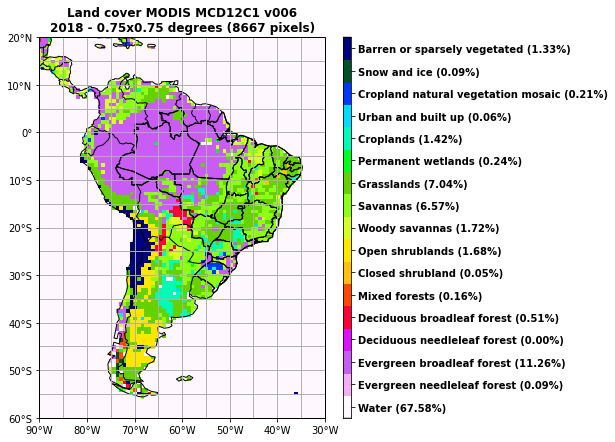

In [12]:
%%time

# Grid for one map.
axgr = south_america(
    figsize=(14, 7),
    nrows_ncols=(1, 1),
    titles=[
        f"Land cover MODIS MCD12C1 v006\n2018 - 0.75x0.75 degrees ({total} pixels)"
    ]
)

# Plot mean results.
plotmap = DA_reg.plot(
    ax=axgr[0],
    vmin=int(0),
    vmax=int(16),
    levels=np.arange(0, 18, 1),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)   

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.cbar_axis.set_ticks(np.arange(0, 17, 1) + 0.5)

# Make colorbar y ticks as strings.
ylabels = [classes_dict[key] + str(" (%.2f%%)" %(percentages[key])) for key in range(17)]
cb.cbar_axis.axes.yaxis.set_ticklabels(ylabels, weight="bold")

# Save figures.
plt.savefig(
    fig_path + "land_cover_igbp_modis2.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

In [13]:
# Attributes for features.
now = datetime.now()
now_str = now.strftime("%B %d, %Y; %Hh:%Mmin:%Ss")
attrs={
    "author": "Alex Araujo <alex.fate2000@gmail.com>",
    "built": now_str,
    "name": "Land cover MODIS MCD12C1 v006 2018 0.75x0.75 degrees South America",
    "spatial": "0.75x0.75",
    "temporal": "2018"
}

# Export results as a netcdf file.
DS = DA_reg.to_dataset(name="land_class")
DS = DS.assign_attrs(**attrs)
DS.to_netcdf(
    path="/media/alex/ALEXDATA/data_sets/MODIS/" + \
    "ppdata_land_cover_075x075_2018_south_america.nc", 
    mode="w" 
)